[View in Colaboratory](https://colab.research.google.com/github/kyokicchi/kaggle_codes/blob/master/trainXGBmodel.ipynb)

In [1]:
!pip install --upgrade xgboost

    100% |████████████████████████████████| 15.8MB 2.3MB/s 
  Found existing installation: xgboost 0.7.post4
    Uninstalling xgboost-0.7.post4:
      Successfully uninstalled xgboost-0.7.post4


In [0]:
import xgboost as xgb
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab import files
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, mean_squared_error
import pickle
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
%cd ../content/gdrive/My Drive/projects/
%ls

/content/gdrive/My Drive/projects
model_LGB.sav  model_NN.h5  model_XGB.sav  user_train_n.csv


In [0]:
s_data = 'user_train_n.csv'
filename = 'model_XGB.sav'
s_col_tgt = 'transactionRevenue_sum'
l_col_drop = [s_col_tgt]


In [6]:
%%time
df_train = pd.read_csv(s_data, index_col = 0)

CPU times: user 4.48 s, sys: 603 ms, total: 5.09 s
Wall time: 7.19 s


In [7]:
%%time
df_y = df_train[s_col_tgt]
df_x = df_train.drop(l_col_drop, axis=1)

CPU times: user 53.5 ms, sys: 111 ms, total: 164 ms
Wall time: 163 ms


In [8]:
%%time
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y)
x_eval, x_valid, y_eval, y_valid = train_test_split(x_test, y_test)


CPU times: user 518 ms, sys: 58.2 ms, total: 576 ms
Wall time: 581 ms


In [12]:
%env JOBLIB_TEMP_FOLDER=/tmp

model = xgb.XGBRegressor()
params = {'max_depth': [2,4,6]}

cv = model_selection.GridSearchCV(
                  model,
                  params,
                  cv=3,
                  n_jobs=-1,
                  verbose=2)


env: JOBLIB_TEMP_FOLDER=/tmp


In [16]:
%%time
params = {"early_stopping_rounds": 10,
              "eval_set": [[x_test, y_test]]}

# cv.fit(x_train, y_train,params)

cv.fit(x_train, y_train)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] max_depth=2 .....................................................
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=  44.8s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=  45.6s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=2, total=  45.5s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total= 1.4min
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total= 1.4min
[CV] max_depth=6 .....................................................
[CV] ...................................... max_depth=4, total= 1.4min
[CV] max_depth=6 .

[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  6.6min finished


CPU times: user 42.5 s, sys: 549 ms, total: 43 s
Wall time: 7min 17s


In [17]:
print(cv.best_params_, cv.best_score_)

{'max_depth': 2} 0.12673069386402608


In [18]:
model = xgb.XGBRegressor(**cv.best_params_)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [19]:
%%time
pickle.dump(model, open(filename, 'wb'))

#files.download(filename) 

CPU times: user 446 µs, sys: 1.98 ms, total: 2.43 ms
Wall time: 212 ms


In [20]:
pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(rmse)

183135143.37576127


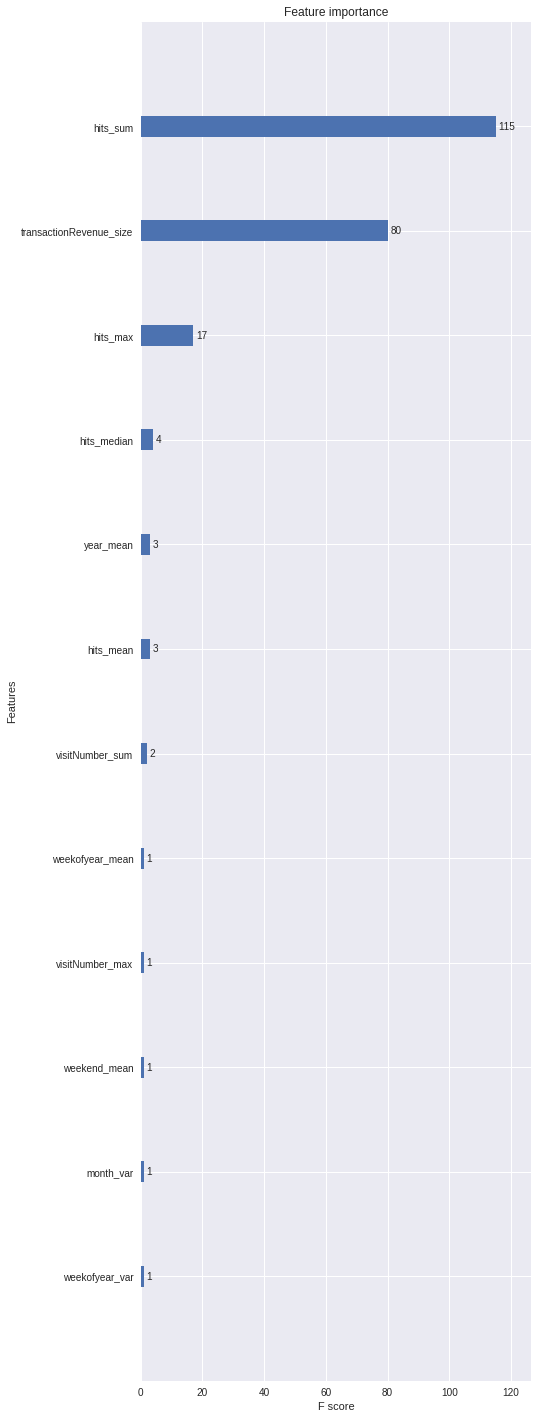

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 25))
xgb.plot_importance(model, ax=ax)
plt.show()